In [1]:
import sys
import triton

sys.path.append("../../build/cuda-snippets/matmul/")

import matmul

In [2]:
import torch

a = torch.randn(1024, 1024, device="cuda", dtype=torch.float32)
b = torch.randn(1024, 1024, device="cuda", dtype=torch.float32)

c = matmul.matmul(a, b)

print("match: ", torch.allclose(c, a @ b))

match:  True


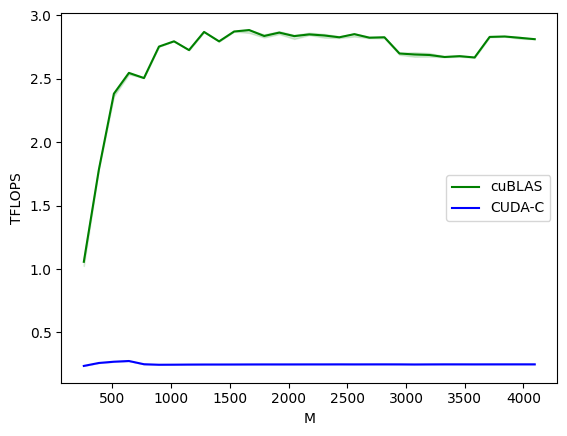

In [3]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["M", "N", "K"],
        x_vals=[128 * i for i in range(2, 33)],
        line_arg="provider",
        line_vals=["cuBLAS", "CUDA-C"],
        line_names=["cuBLAS", "CUDA-C"],
        styles=[("green", "-"), ("blue", "-")],
        ylabel="TFLOPS",
        plot_name="matmul-performance",
        args={},
    )
)
def matmul_benchmark(M, N, K, provider):
    a = torch.randn((M, K), device="cuda")
    b = torch.randn((K, N), device="cuda")
    quantiles = [0.5, 0.2, 0.8]
    if provider == "cuBLAS":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: torch.matmul(a, b), quantiles=quantiles
        )
    if provider == "CUDA-C":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: matmul.matmul(a, b), quantiles=quantiles
        )
    perf = lambda ms: 2 * M * N * K * 1e-9 / ms
    return perf(ms), perf(max_ms), perf(min_ms)


matmul_benchmark.run(show_plots=True, print_data=False)